# The first experiment: use generated dataset from sklearn to evaluate the trade-off power of different algorithms.


In [1]:
%load_ext autoreload
%autoreload 2
from lib.reduction_algorithms import EGDIS, POP, CL, WCL
from lib.callbacks import MonitorAndSaveParameters
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.neural_network import MLPClassifier
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras

Using TensorFlow backend.


In [2]:
def show_training(history, idx=None):
    
    acc = history['acc']
    val_acc = history["val_acc"]

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([np.argmax(val_acc), np.argmax(val_acc)],
          plt.ylim(), label='Best accuracy: ' + str(np.max(val_acc)))
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    # plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [3]:
sample_blobs, sample_blobs_y = make_blobs(n_samples=2000, centers=2, shuffle=True, n_features=2, cluster_std=2)
sample_moons, sample_moons_y = make_moons(n_samples=2000, shuffle=True, noise=0.1)
sample_circles, sample_circles_y = make_circles(n_samples=2000, shuffle=True, noise=0.05)

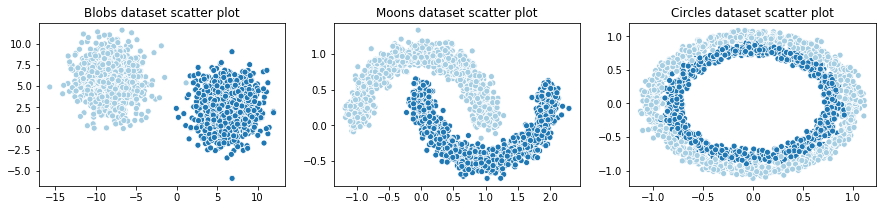

In [4]:
axes = plt.subplots(1,3, figsize=(15,3))
sns.scatterplot(sample_blobs[:,0], sample_blobs[:,1], hue=sample_blobs_y, ax=axes[1][0], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][0].set_title("Blobs dataset scatter plot")
sns.scatterplot(sample_moons[:,0], sample_moons[:,1], hue=sample_moons_y, ax=axes[1][1], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][1].set_title("Moons dataset scatter plot")
sns.scatterplot(sample_circles[:,0], sample_circles[:,1], hue=sample_circles_y, ax=axes[1][2], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][2].set_title("Circles dataset scatter plot")
plt.show()

In [5]:
def check_distribution(x, y, axes, name):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    sns.scatterplot(x_train[:,0], x_train[:,1], hue=y_train, ax=axes[0], legend=False, palette=sns.color_palette("Paired", 2))
    axes[0].set_title("{} training set scatter plot".format(name))
    
    sns.scatterplot(x_valid[:,0], x_valid[:,1], hue=y_valid, ax=axes[1], legend=False, palette=sns.color_palette("Paired", 2))
    axes[1].set_title("{} validation set scatter plot".format(name))
    
    sns.scatterplot(x_test[:,0], x_test[:,1], hue=y_test, ax=axes[2], legend=False, palette=sns.color_palette("Paired", 2))
    axes[1].set_title("{} testing set scatter plot".format(name))

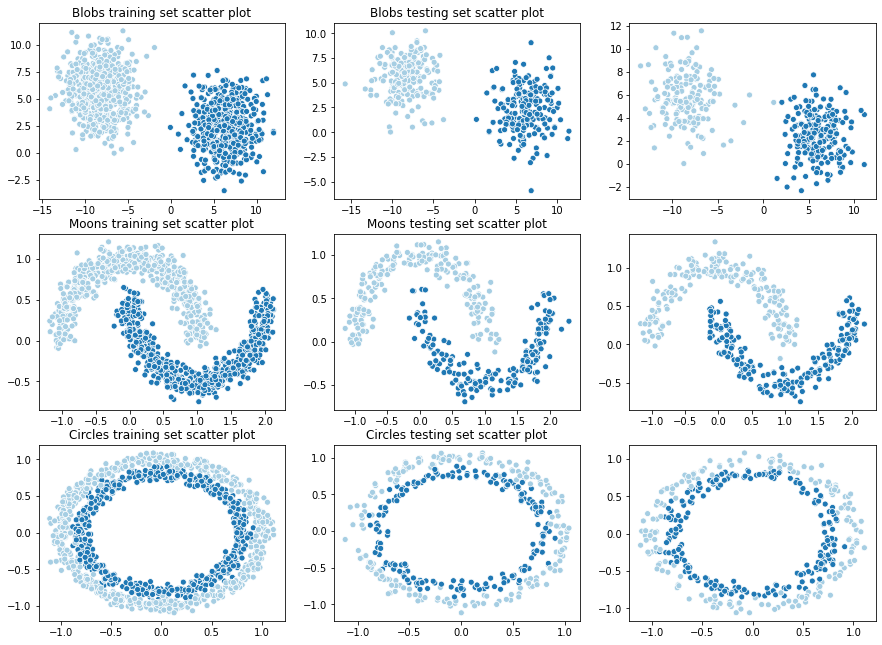

In [6]:
# Visualise the train, validate, test set.
fig, axes = plt.subplots(3,3, figsize=(15,11))
check_distribution(sample_blobs, sample_blobs_y, axes[0, :], name="Blobs")
check_distribution(sample_moons, sample_moons_y, axes[1, :], name="Moons")
check_distribution(sample_circles, sample_circles_y, axes[2, :], name="Circles")

plt.show()

## 1. Explore the original dataset
First, I trained the original dataset to convergence and get the best validation accuracy.

In [7]:
def train(x, y, classes, keep_best=5, selected_train=None, selected_train_y=None):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    
    # train with selected subset.
    if isinstance(selected_train, np.ndarray):
        x_train = selected_train
        y_train = selected_train_y
        print("Use selected {} samples to train the network.".format(len(y_train)))
        
    train_acc_list = []
    val_acc_list = []
    best_clf_list = []
    
    if classes != 1:
        y_train = to_categorical(y_train, num_classes=classes)
        y_valid = to_categorical(y_valid, num_classes=classes)
        y_test = to_categorical(y_test, num_classes=classes)
        
    for i in range(30):
        clf = keras.Sequential([
            keras.layers.InputLayer([2]),
            keras.layers.Dense(8, activation="tanh"),
            keras.layers.Dense(8, activation="tanh"),
            keras.layers.Dense(classes, activation='softmax', kernel_initializer="he_uniform")
        ])
        
        clf.compile(optimizer=keras.optimizers.Adam(0.05),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

        history = {}
        
        default = clf.fit(x_train, y_train, batch_size=200, epochs=1000, validation_data=(x_valid, y_valid), verbose=0, callbacks=[
                                        MonitorAndSaveParameters(history, 200, len(y_valid),
                                                                 early_stop=True)])
        history["acc"] = default.history["accuracy"]
        history["loss"] = default.history["loss"]
#         show_training(history)
#     print("Evaluating...")
        val_acc_list.append(max(history["val_acc"])) 
        train_acc_list.append(history["acc"])
#         print("The training set accuracy is: {}".format(history["acc"][np.argmax(max(history["val_acc"]))]))
        best_clf_list.append(clf)
        if len(best_clf_list) > keep_best:
            worst_idx = np.argmin(val_acc_list)
            del best_clf_list[worst_idx]
            del val_acc_list[worst_idx]
            del train_acc_list[worst_idx]
    
    # Evaluate the best keep_best classifier
    test_acc_list = []
    for classifier in best_clf_list:
        evaluate = {}
        test_results = classifier.evaluate(x_test, y_test, batch_size=200, verbose=0, callbacks=[
                                MonitorAndSaveParameters(evaluate, 200, len(y_test))])
        acc = evaluate["val_acc"][0]
        test_acc_list.append(acc)
        print("The test set accuracy is: {:.3f}, the test set loss is: {:.3f}".format(acc, evaluate["val_loss"][0]))
        
    return best_clf_list, val_acc_list, train_acc_list, test_acc_list

### 1.1 Blobs

In [8]:
# train the blob dataset and report the evaluation acc.
clf_blobs, acc_blobs, acc_trend_blobs, acc_test_blobs = train(sample_blobs, sample_blobs_y, 2)

Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1

### 1.2 Moons

In [9]:
clf_moons, acc_moons, acc_trend_moons, acc_test_moons = train(sample_moons, sample_moons_y, 2)

Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1

##  1.3 Circles

In [10]:
clf_circles, acc_circles, acc_trend_circles, acc_test_circles = train(sample_circles, sample_circles_y, 2)

Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9837500154972076
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with vali

## 1.4 Show classification results

In [11]:
# plot the classification results.
blobs_y_pred = clf_blobs[np.argmax(acc_blobs)].predict_classes(sample_blobs)
moons_y_pred = clf_moons[np.argmax(acc_moons)].predict_classes(sample_moons)
circles_y_pred = clf_circles[np.argmax(acc_circles)].predict_classes(sample_circles)

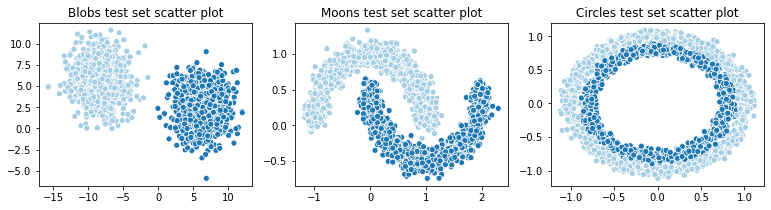

In [12]:
axes = plt.subplots(1,3, figsize=(13,3))
sns.scatterplot(sample_blobs[:,0], sample_blobs[:,1], hue=blobs_y_pred, ax=axes[1][0], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][0].set_title("Blobs test set scatter plot")
sns.scatterplot(sample_moons[:,0], sample_moons[:,1], hue=moons_y_pred, ax=axes[1][1], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][1].set_title("Moons test set scatter plot")
sns.scatterplot(sample_circles[:,0], sample_circles[:,1], hue=circles_y_pred, ax=axes[1][2], legend=False, palette=sns.color_palette("Paired", 2))
axes[1][2].set_title("Circles test set scatter plot")

ylim_blobs = axes[1][0].get_ylim()
xlim_blobs = axes[1][0].get_xlim()

ylim_moons = axes[1][1].get_ylim()
xlim_moons = axes[1][1].get_xlim()

ylim_circles = axes[1][2].get_ylim()
xlim_circles = axes[1][2].get_xlim()

plt.show()

## 2. Reduce the dataset with four different algorithms
Second, I reduced the original dataset and test the classification accuracy.

In [122]:
# init all four data reduction algorithms.
egdis = EGDIS()
pop = POP()
# CL needs the information about the dataset.
cl = CL()
wcl = WCL()

In [14]:
def run_pop(x, y, classes, ylim, xlim):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    print("Now try to run the algorithm POP with the generated sample dataset.")
    # test the pop algorithm
    sample_weakness = pop.fit(x_train, y_train)
    ax = sns.distplot(sample_weakness, kde=False, rug=True);
    ax.set_title("The distribution of the weakness")
    plt.show()
    print("------------------ Start to select subsets ------------------")
    
    trend_list = []
    test_list = []
    for i in range(int(sample_weakness.max())):
        selected_index = sample_weakness <= i
        selected_samples = x_train[selected_index]
        selected_y = y_train[selected_index]
        print("Keep instances with weakness <= {}, there are {} samples".format(i, len(selected_samples)))
        plot_y = y_train.copy()
        plot_y[selected_index] = classes
        ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
        ax.set_title("Selected samples with the POP algorithm with weakness <= {}".format(i))
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.show()
        # train with the selected samples.
        clfs, accs, trend, test = train(x, y, classes, selected_train=selected_samples, selected_train_y=selected_y)
        
        trend_list.append(trend)
        test_list.append(test)
        
        y_pred = clfs[np.argmax(accs)].predict_classes(x)
        ax = sns.scatterplot(x[:,0], x[:,1], hue=y_pred, legend=False, palette=sns.color_palette("Paired", classes))
        ax.set_title("Predicted results with the highest validation accuracy classifier")
        plt.show()
        print("-----------------------------------------------------")
    
    return trend_list, test_list

In [15]:
def run_egdis(x, y, classes, ylim, xlim):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    selected_egdis_idx = egdis.fit(x_train, y_train)
    print("Now try to run the algorithm EGDIS with the generated sample dataset.")
    print("Selected {} samples".format(len(selected_egdis_idx)))
    plot_y = y_train.copy()
    plot_y[selected_egdis_idx] = classes
    ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
    ax.set_title("Samples selected by the EGDIS algorithm")
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.show()
    
    # train with the selected samples.
    clfs, accs, trend, test = train(x, y, classes, selected_train=x_train[selected_egdis_idx], selected_train_y=y_train[selected_egdis_idx])
    y_pred = clfs[np.argmax(accs)].predict_classes(x)
    ax = sns.scatterplot(x[:,0], x[:,1], hue=y_pred, legend=False, palette=sns.color_palette("Paired", classes))
    ax.set_title("Predicted results with the highest validation accuracy classifier")
    plt.show()
    return trend, test

In [16]:
def run_cl(x, y, classes, ylim, xlim, clf):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    cl.fit_dataset(clf=clf)
    rank, scores = cl.fit(x_train, to_categorical(y_train, num_classes=classes))
    
    trend_list = []
    test_list = []
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        selected_x = x_train[selected_data_idx]
        selected_y = y_train[selected_data_idx]
        print("------------------ Start to select subsets ------------------")
        print("Selected {} percent training data.".format(i*10))
        
        plot_y = y_train.copy()
        plot_y[selected_data_idx] = classes
        ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
        
        ax.set_title("{} percent Samples selected by the CL algorithm".format(i*10))
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.show()
        
        # train with the selected samples.
        clfs, accs, trend, test = train(x, y, classes, selected_train=selected_x, selected_train_y=selected_y)
        trend_list.append(trend)
        test_list.append(test)
        y_pred = clfs[np.argmax(accs)].predict_classes(x)
        ax = sns.scatterplot(x[:,0], x[:,1], hue=y_pred, legend=False, palette=sns.color_palette("Paired", classes))
        ax.set_title("Predicted results with the highest validation accuracy classifier")
        plt.show()
    return trend_list, test_list

##  2.1 Blobs

Now try to run the algorithm POP with the generated sample dataset.


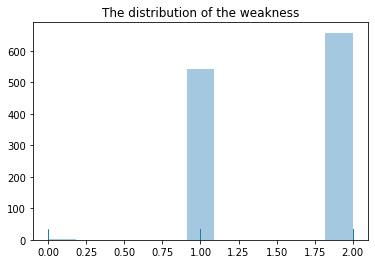

------------------ Start to select subsets ------------------
Keep instances with weakness <= 0, there are 2 samples


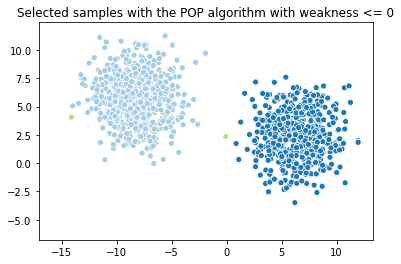

Use selected 2 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 0.9262500107288361
Restoring best model weights with validation accuracy: 0.9424999952316284
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 0.8899999856948853
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 0.8687500059604645
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9262500107288361
Restoring best model weights with validation accuracy: 0.8375000059604645
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

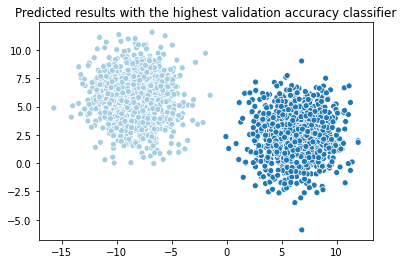

-----------------------------------------------------
Keep instances with weakness <= 1, there are 543 samples


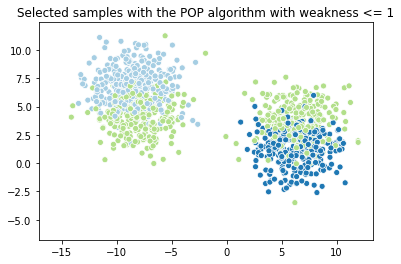

Use selected 543 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

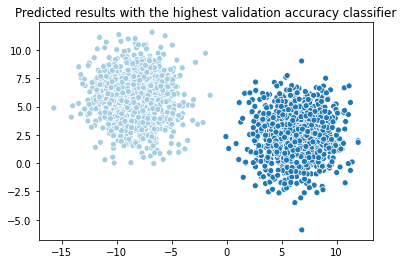

-----------------------------------------------------


In [17]:
trend_list, test_list = run_pop(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs)

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 144 samples


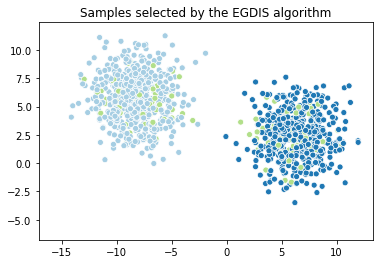

Use selected 144 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

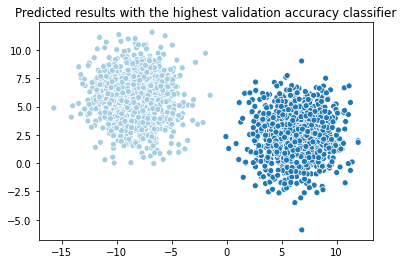

In [18]:
trend_list, test_list = run_egdis(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs)

------------------ Start to select subsets ------------------
Selected 10 percent training data.


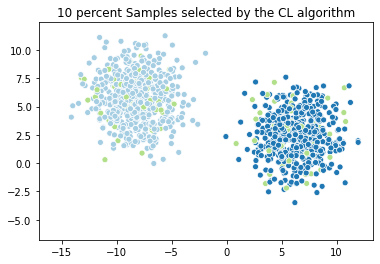

Use selected 120 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

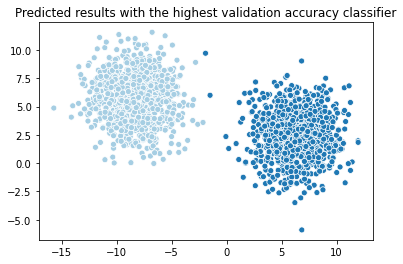

------------------ Start to select subsets ------------------
Selected 30 percent training data.


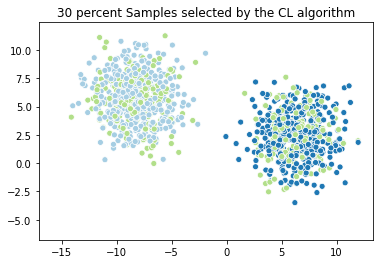

Use selected 360 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

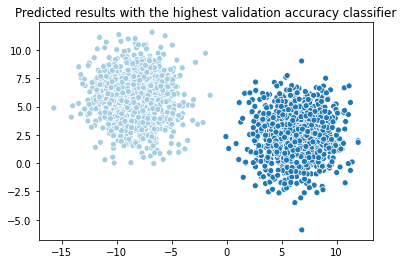

------------------ Start to select subsets ------------------
Selected 50 percent training data.


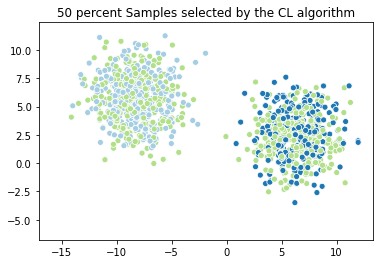

Use selected 600 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

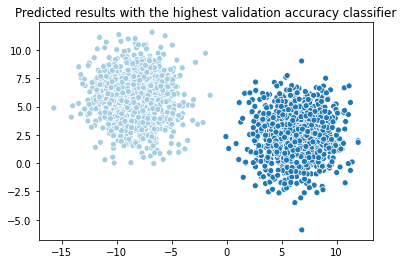

------------------ Start to select subsets ------------------
Selected 70 percent training data.


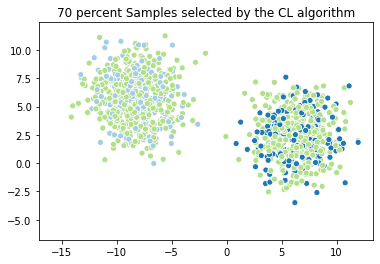

Use selected 840 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

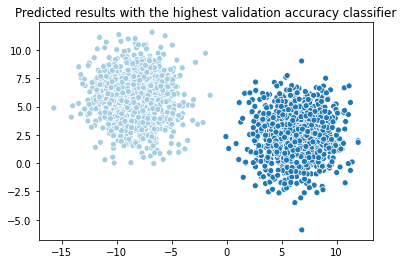

------------------ Start to select subsets ------------------
Selected 90 percent training data.


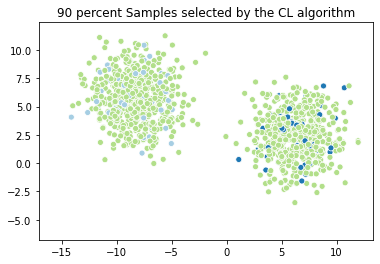

Use selected 1080 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restorin

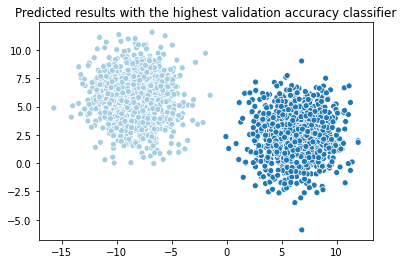

In [19]:
trend_list, test_list = run_cl(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf_blobs[np.argmax(acc_blobs)])

In [20]:
# trend_list, test_list = run_wcl(sample_blobs, sample_blobs_y, ylim_blobs, xlim_blobs)

## 2.2 Moons

Now try to run the algorithm POP with the generated sample dataset.


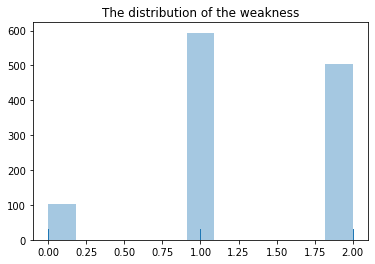

------------------ Start to select subsets ------------------
Keep instances with weakness <= 0, there are 102 samples


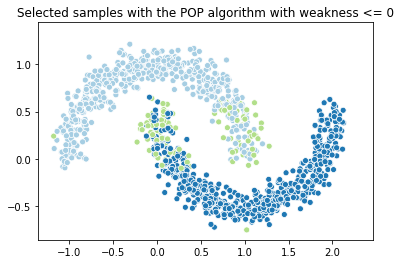

Use selected 102 samples to train the network.
Restoring best model weights with validation accuracy: 0.6387500166893005
Restoring best model weights with validation accuracy: 0.6074999868869781
Restoring best model weights with validation accuracy: 0.6749999821186066
Restoring best model weights with validation accuracy: 0.6487500071525574
Restoring best model weights with validation accuracy: 0.7787500023841858
Restoring best model weights with validation accuracy: 0.6087499856948853
Restoring best model weights with validation accuracy: 0.8912499845027924
Restoring best model weights with validation accuracy: 0.6274999976158142
Restoring best model weights with validation accuracy: 0.5600000023841858
Restoring best model weights with validation accuracy: 0.5974999964237213
Restoring best model weights with validation accuracy: 0.6012499928474426
Restoring best model weights with validation accuracy: 0.6212499737739563
Restoring best model weights with validation accuracy: 0.60249999

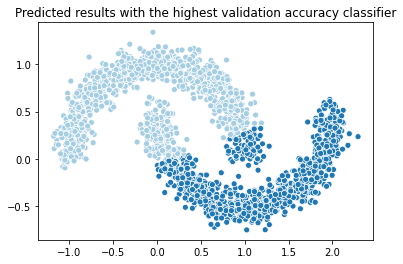

-----------------------------------------------------
Keep instances with weakness <= 1, there are 696 samples


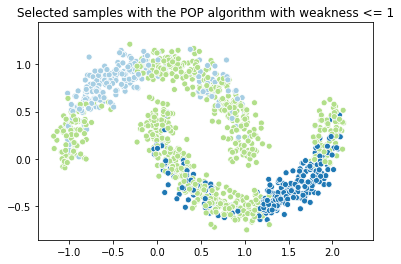

Use selected 696 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

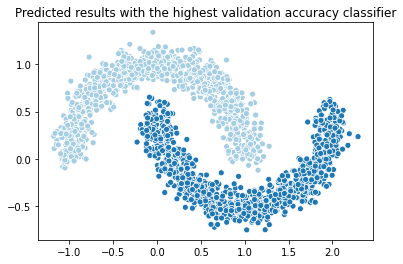

-----------------------------------------------------


In [21]:
trend_list, test_list = run_pop(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons)

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 186 samples


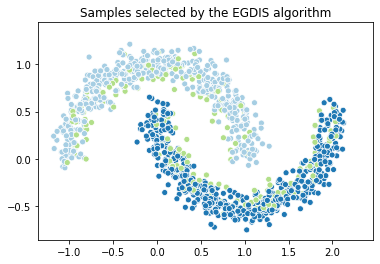

Use selected 186 samples to train the network.
Restoring best model weights with validation accuracy: 0.9950000047683716
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.9950000047683716
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.9925000071525574
Restoring best model weights with validation accuracy: 0.9950000047683716
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.9912500083446503
Restoring best model weights with validation accuracy: 0.9962500035762787
Restoring best model weights with validation accuracy: 0.99500000

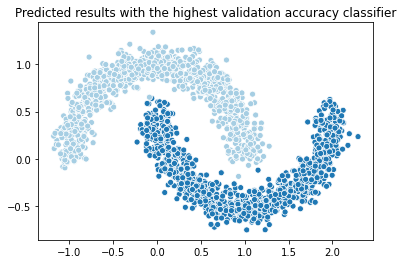

In [113]:
trend_list, test_list = run_egdis(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons)

------------------ Start to select subsets ------------------
Selected 10 percent training data.


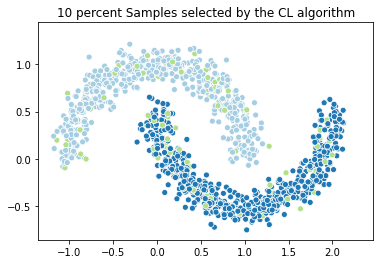

Use selected 120 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 0.9987500011920929
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy

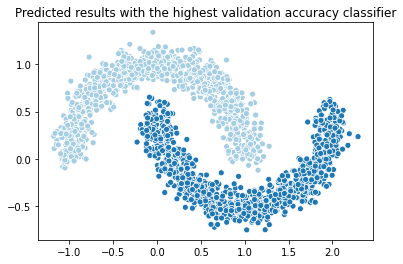

------------------ Start to select subsets ------------------
Selected 30 percent training data.


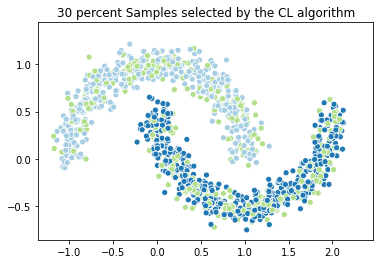

Use selected 360 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

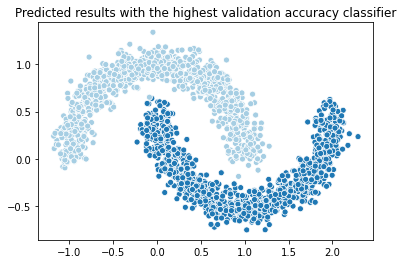

------------------ Start to select subsets ------------------
Selected 50 percent training data.


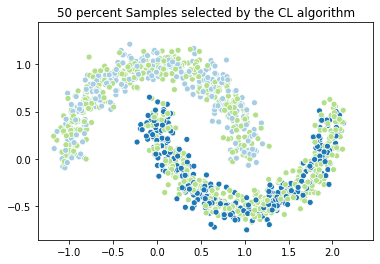

Use selected 600 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

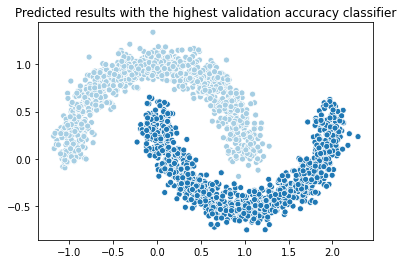

------------------ Start to select subsets ------------------
Selected 70 percent training data.


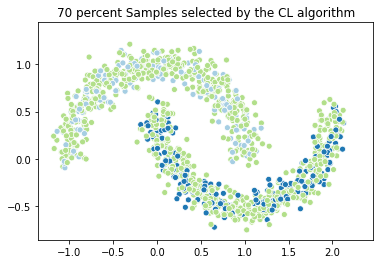

Use selected 840 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring

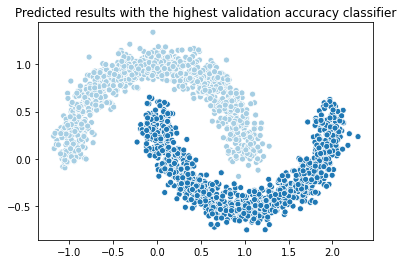

------------------ Start to select subsets ------------------
Selected 90 percent training data.


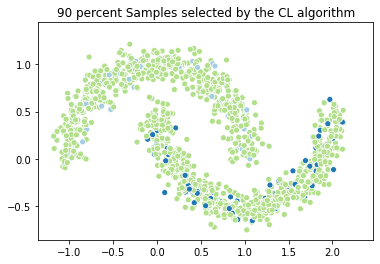

Use selected 1080 samples to train the network.
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restoring best model weights with validation accuracy: 1.0
Restorin

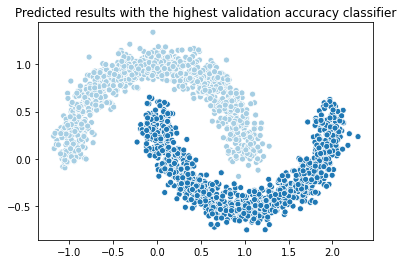

In [23]:
trend_list, test_list = run_cl(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf_moons[np.argmax(acc_moons)])

## 2.3 Circles

Now try to run the algorithm POP with the generated sample dataset.


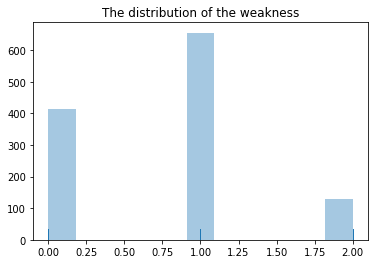

------------------ Start to select subsets ------------------
Keep instances with weakness <= 0, there are 415 samples


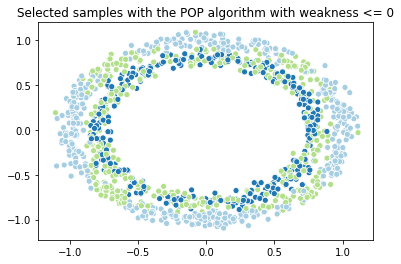

Use selected 415 samples to train the network.
Restoring best model weights with validation accuracy: 0.9650000035762787
Restoring best model weights with validation accuracy: 0.9574999809265137
Restoring best model weights with validation accuracy: 0.9624999761581421
Restoring best model weights with validation accuracy: 0.9574999809265137
Restoring best model weights with validation accuracy: 0.9587499797344208
Restoring best model weights with validation accuracy: 0.9637500047683716
Restoring best model weights with validation accuracy: 0.9624999761581421
Restoring best model weights with validation accuracy: 0.9574999809265137
Restoring best model weights with validation accuracy: 0.9650000035762787
Restoring best model weights with validation accuracy: 0.9625000059604645
Restoring best model weights with validation accuracy: 0.9537499845027924
Restoring best model weights with validation accuracy: 0.9724999964237213
Restoring best model weights with validation accuracy: 0.95999997

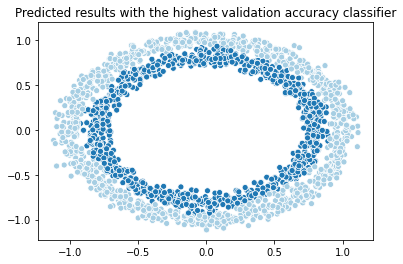

-----------------------------------------------------
Keep instances with weakness <= 1, there are 1070 samples


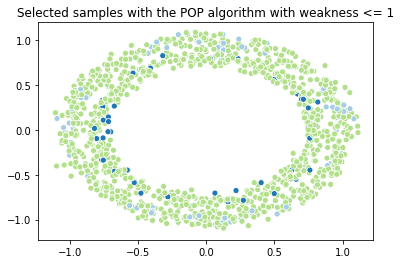

Use selected 1070 samples to train the network.
Restoring best model weights with validation accuracy: 0.9837500154972076
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9837500154972076
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9812500

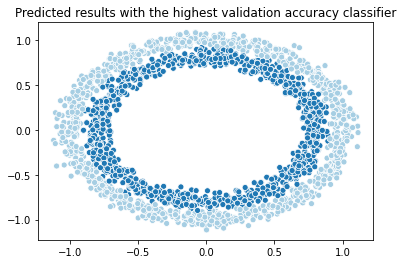

-----------------------------------------------------


In [24]:
trend_list, test_list = run_pop(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles)

Now try to run the algorithm EGDIS with the generated sample dataset.
Selected 206 samples


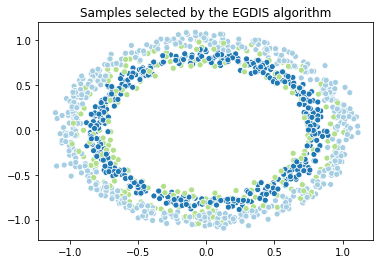

Use selected 206 samples to train the network.
Restoring best model weights with validation accuracy: 0.9699999988079071
Restoring best model weights with validation accuracy: 0.9724999964237213
Restoring best model weights with validation accuracy: 0.9737499952316284
Restoring best model weights with validation accuracy: 0.9712499976158142
Restoring best model weights with validation accuracy: 0.9737499952316284
Restoring best model weights with validation accuracy: 0.9737499952316284
Restoring best model weights with validation accuracy: 0.9699999988079071
Restoring best model weights with validation accuracy: 0.9737499952316284
Restoring best model weights with validation accuracy: 0.9762499928474426
Restoring best model weights with validation accuracy: 0.9750000238418579
Restoring best model weights with validation accuracy: 0.9737499952316284
Restoring best model weights with validation accuracy: 0.961249977350235
Restoring best model weights with validation accuracy: 0.795000016

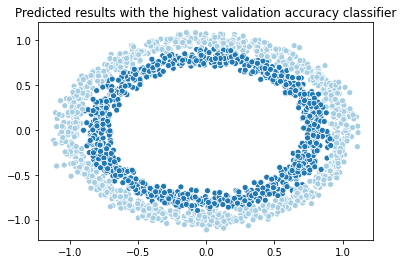

In [25]:
trend_list, test_list = run_egdis(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles)

------------------ Start to select subsets ------------------
Selected 10 percent training data.


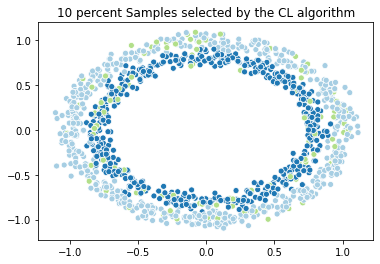

Use selected 120 samples to train the network.
Restoring best model weights with validation accuracy: 0.9737500250339508
Restoring best model weights with validation accuracy: 0.9725000262260437
Restoring best model weights with validation accuracy: 0.9737500250339508
Restoring best model weights with validation accuracy: 0.96875
Restoring best model weights with validation accuracy: 0.976250022649765
Restoring best model weights with validation accuracy: 0.976250022649765
Restoring best model weights with validation accuracy: 0.9637499749660492
Restoring best model weights with validation accuracy: 0.9700000286102295
Restoring best model weights with validation accuracy: 0.9700000286102295
Restoring best model weights with validation accuracy: 0.9750000238418579
Restoring best model weights with validation accuracy: 0.9599999785423279
Restoring best model weights with validation accuracy: 0.9637499749660492
Restoring best model weights with validation accuracy: 0.9712499976158142
Rest

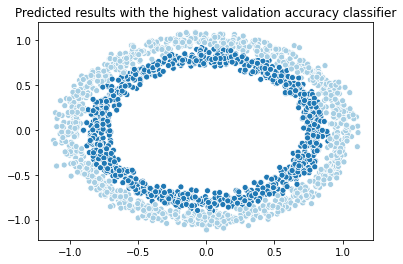

------------------ Start to select subsets ------------------
Selected 30 percent training data.


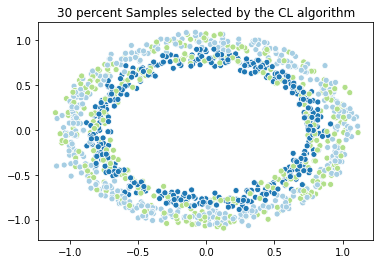

Use selected 360 samples to train the network.
Restoring best model weights with validation accuracy: 0.9775000214576721
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9750000238418579
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.976250022649765
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9775000214576721
Restoring best model weights with validation accuracy: 0.978750020

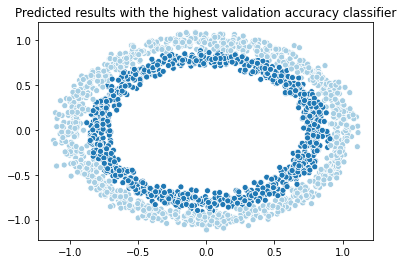

------------------ Start to select subsets ------------------
Selected 50 percent training data.


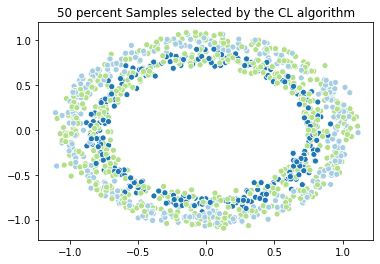

Use selected 600 samples to train the network.
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9775000214576721
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9837500154972076
Restoring best model weights with validation accuracy: 0.98125001

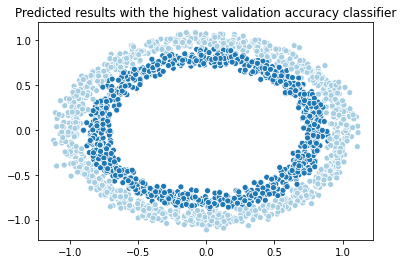

------------------ Start to select subsets ------------------
Selected 70 percent training data.


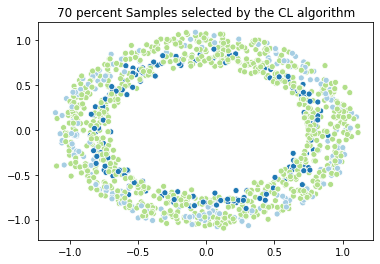

Use selected 840 samples to train the network.
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9800000190734863
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.98000001

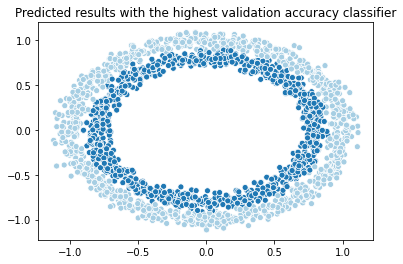

------------------ Start to select subsets ------------------
Selected 90 percent training data.


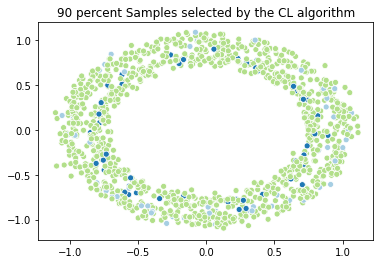

Use selected 1080 samples to train the network.
Restoring best model weights with validation accuracy: 0.9837500154972076
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9837500154972076
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9812500178813934
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9850000143051147
Restoring best model weights with validation accuracy: 0.9787500202655792
Restoring best model weights with validation accuracy: 0.9825000166893005
Restoring best model weights with validation accuracy: 0.9825000

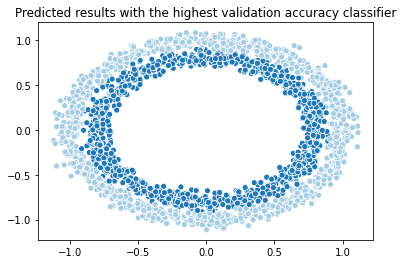

In [26]:
trend_list, test_list = run_cl(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf_circles[np.argmax(acc_circles)])

## Comment
EGDIS can select samples around the boundary. Therefore the relative accuracy is high. POP and CL are not stable. They cannot cover the whole boundary. Actually, because the scores are all above 0.9, the selection process tends to be uniform random selection. Also, CL tends to select inner samples because they have higher classification scores.

## 3. CL Score distribution analysis
Now we plot the score distribution acquired by CL to show illustrate how CL works

In [108]:
def show_CL_scores(x, y, classes, ylim, xlim, clf, percent_mode=False):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    cl.fit_dataset(clf=clf)
    rank, scores = cl.fit(x_train, to_categorical(y_train, num_classes=classes))
    ax = sns.distplot(scores, kde=True, rug=True, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]);
    ax.set_title("The distribution of the CL scores")
    plt.show()
    image_idx = 0
    color_palette = ["#3E77B0", "#AECDE1", "#BBDE93"]
    fig, axes = plt.subplots(3, 3, figsize=(16,13))
    for i in range(9, 0, -1):
        score = i / 10.
        plot_y = y_train.copy()
        if percent_mode:
            percent = 1 - score
            selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
            plot_y[selected_data_idx] = classes
            ax = sns.scatterplot(x_train[:,0], x_train[:,1], ax=axes[image_idx//3][image_idx%3], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
            ax.set_title("Top {:.2f} percent, {} samples".format(percent, len(selected_data_idx)))
            
        else:
            if len(plot_y[scores >= score]) == len(y_train):
                plot_y[scores >= score] = 0
                ax = sns.scatterplot(x_train[:,0], x_train[:,1], ax=axes[image_idx//3][image_idx%3], hue=plot_y, legend=False, palette=sns.color_palette(["#BBDE93"]))
            else:
                plot_y[scores >= score] = classes
                selected_palette = [color_palette[idx] for idx in np.unique(plot_y)]
                ax = sns.scatterplot(x_train[:,0], x_train[:,1], ax=axes[image_idx//3][image_idx%3], hue=plot_y, legend=False, palette=sns.color_palette(selected_palette))
            ax.set_title("Scores >= {}, {} samples".format(score, (scores >= score).sum()))
        image_idx += 1
        plt.ylim(ylim)
        plt.xlim(xlim)
    plt.show()
                
        

## 3.1 Blobs

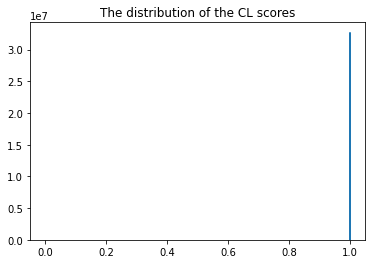

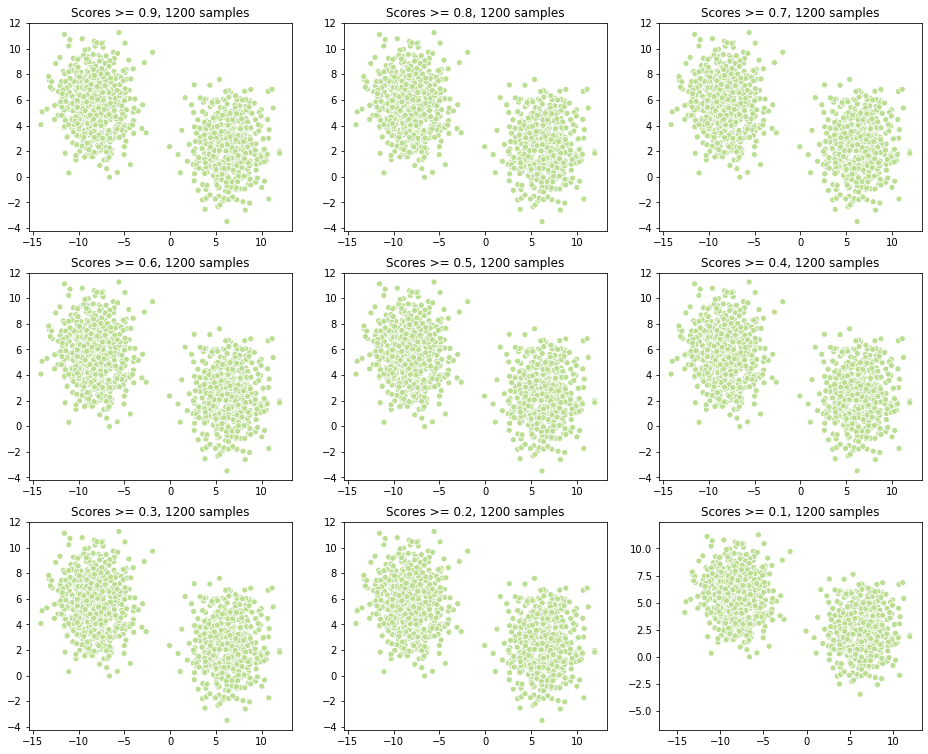

In [109]:
show_CL_scores(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf=clf_blobs[np.argmax(acc_blobs)])

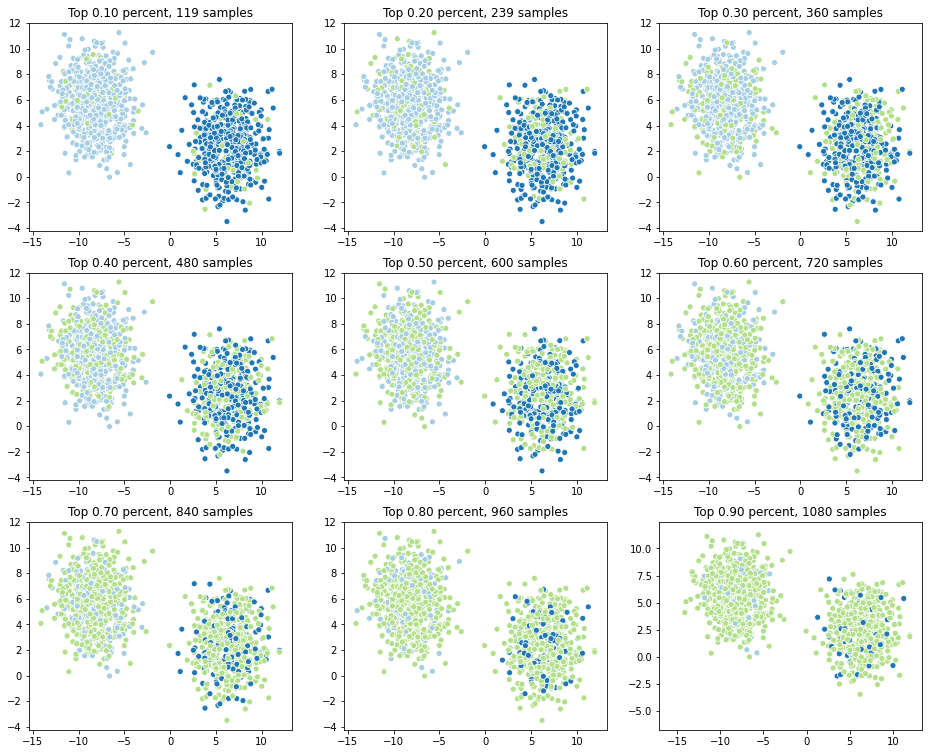

In [77]:
show_CL_scores(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf=clf_blobs[np.argmax(acc_blobs)], percent_mode=True)

## 3.2 Moons

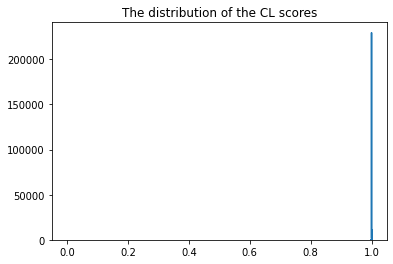

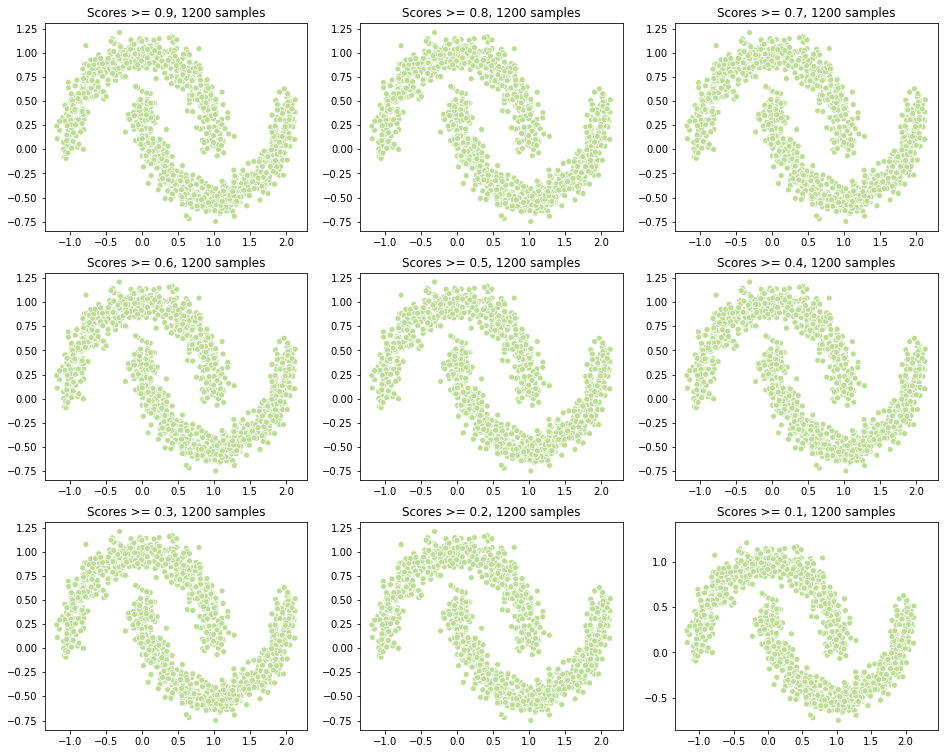

In [110]:
show_CL_scores(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf=clf_moons[np.argmax(acc_moons)])

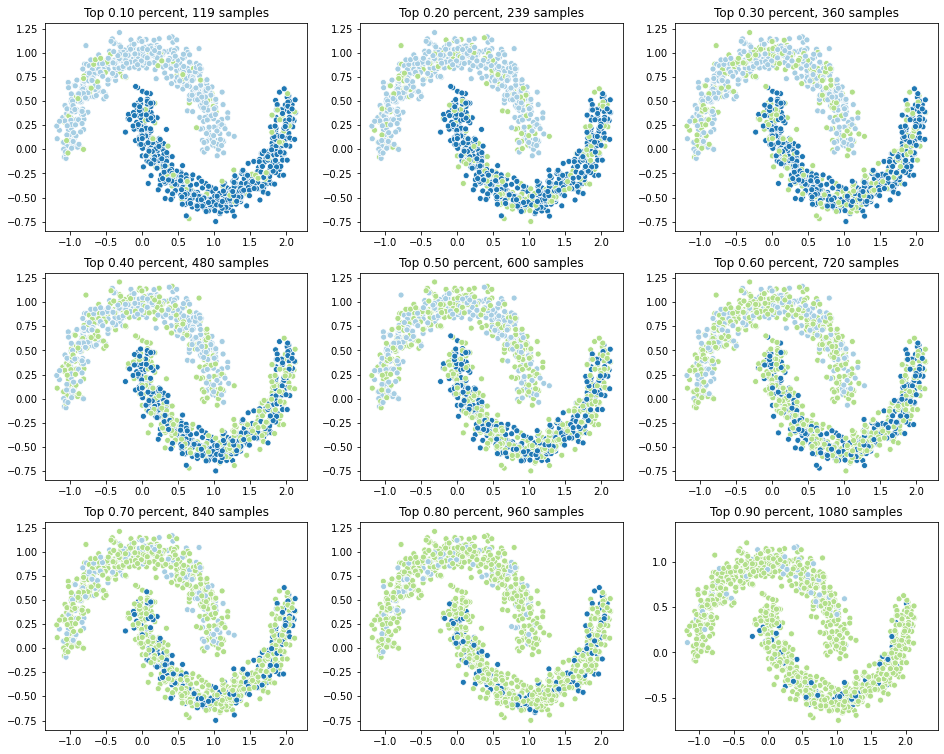

In [34]:
show_CL_scores(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf=clf_moons[np.argmax(acc_moons)], percent_mode=True)

## 3.3 Circles

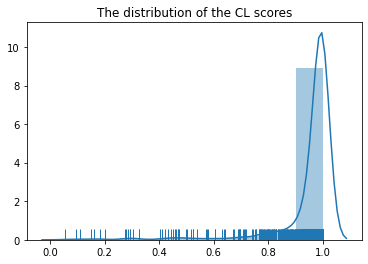

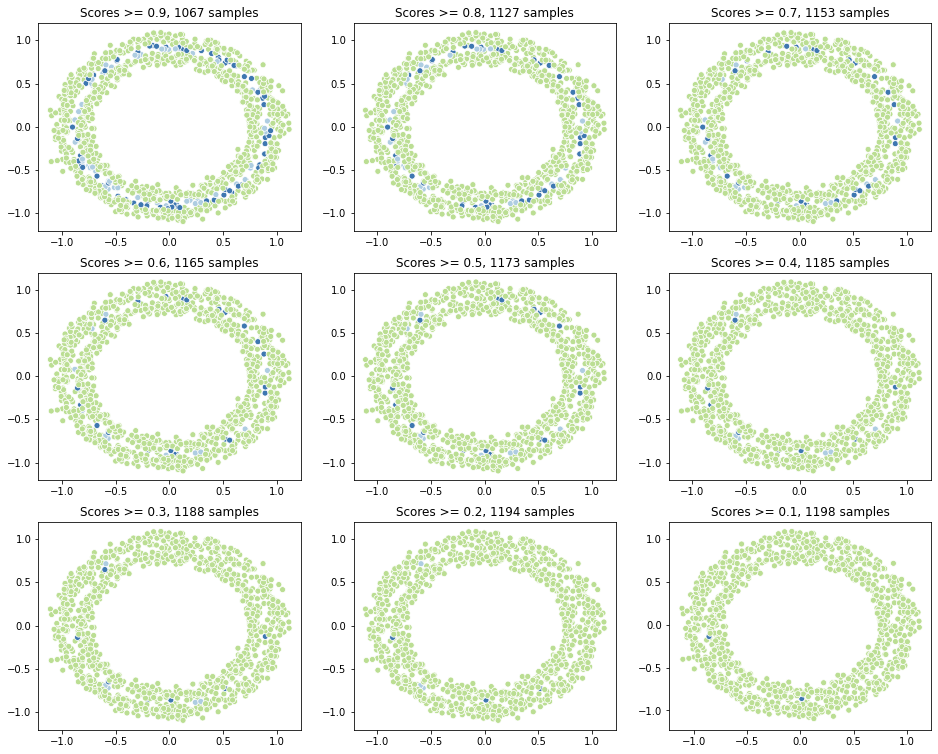

In [111]:
show_CL_scores(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf=clf_circles[np.argmax(acc_circles)])

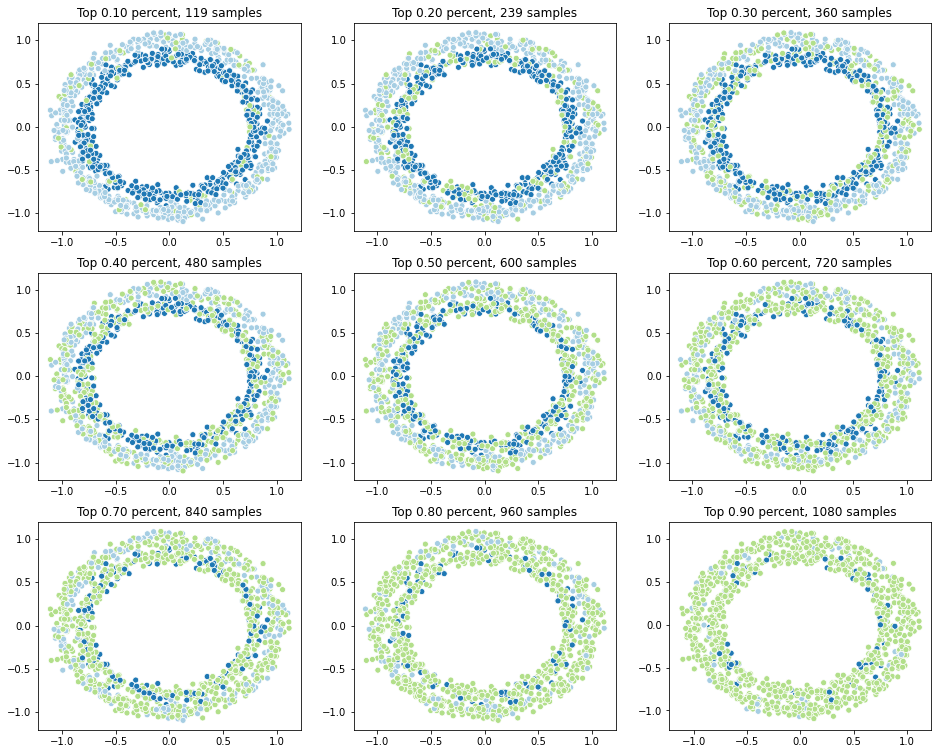

In [88]:
show_CL_scores(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf=clf_circles[np.argmax(acc_circles)], percent_mode=True)

## 4. Calculate the intersection of selected points with CL and EDGIS boundary

In [146]:
def run_wcl(x, y, classes, ylim, xlim, clf):
    x_train, x_valid, x_test = np.split(x, [int(.6 * len(x)), int(.8 * len(x))])
    y_train, y_valid, y_test = np.split(y, [int(.6 * len(y)), int(.8 * len(y))])
    wcl.fit_dataset(clf=clf)
    scores, selected_boundary_idx = wcl.fit(x_train, y_train, classes)
    print("Selected {} boundary instances.".format(len(selected_boundary_idx)))
    plot_y = y_train.copy()
    plot_y[selected_boundary_idx] = classes
    ax = sns.scatterplot(x_train[:,0], x_train[:,1], hue=plot_y, legend=False, palette=sns.color_palette("Paired", classes+1))
    ax.set_title("Selected {} boundary samples with EDGIS".format(len(selected_boundary_idx)))
    plt.show()
    
    for i in range(1, 10, 2):
        percent = i / 10.
        selected_data_idx = np.random.choice(len(y_train), int(percent * len(y_train)), replace=False, p=scores / scores.sum())
        print("Select {:.2f} percent samples, {} overlapping with the pre-selected boundary samples".format(percent*100, len(np.intersect1d(selected_boundary_idx, selected_data_idx)))) 
        

## 4.1 Blobs

In [131]:
run_wcl(sample_blobs, sample_blobs_y, 2, ylim_blobs, xlim_blobs, clf=clf_blobs[np.argmax(acc_blobs)])

(0,)
0.0
0.0
0.0
0.0
0.0


## 4.2 Moons

In [132]:
run_wcl(sample_moons, sample_moons_y, 2, ylim_moons, xlim_moons, clf=clf_moons[np.argmax(acc_moons)])

(0,)
0.0
0.0
0.0
0.0
0.0


## 4.3 Circles

Selected 30 boundary instances.


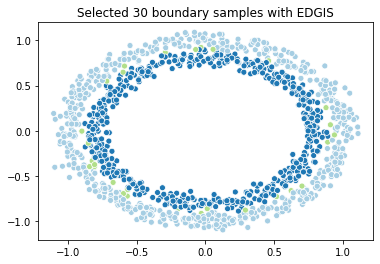

Select 10.00 percent samples, 3 overlapping with the pre-selected boundary samples
Select 30.00 percent samples, 4 overlapping with the pre-selected boundary samples
Select 50.00 percent samples, 7 overlapping with the pre-selected boundary samples
Select 70.00 percent samples, 11 overlapping with the pre-selected boundary samples
Select 90.00 percent samples, 18 overlapping with the pre-selected boundary samples


In [147]:
run_wcl(sample_circles, sample_circles_y, 2, ylim_circles, xlim_circles, clf=clf_circles[np.argmax(acc_circles)])